
# Predicting the Dow Jones with News
#### General Data flow for a Text Related Business Problem

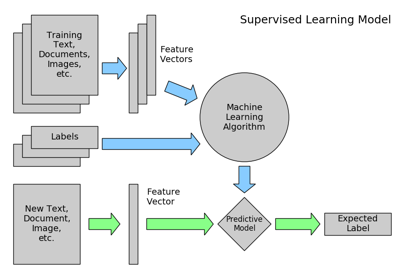

# Problem Statement & Reference Architecture

* **Aim**: Use Reddit News Headlines to predict the movement of Dow Jones Industrial Average.   


* **Data Source**: https://www.kaggle.com/aaron7sun/stocknews 


* **Data Description**: Dow Jones details on Open, High, Low and Close for each day from 2008-08-08 to 2016-07-01 and headlines for those dates from Reddit News. 


* **Methodology**: For this project, we will use GloVe to create our word embeddings and CNNs followed by LSTMs to build our model. This model is based off the work done in this paper https://www.aclweb.org/anthology/C/C16/C16-1229.pdf.

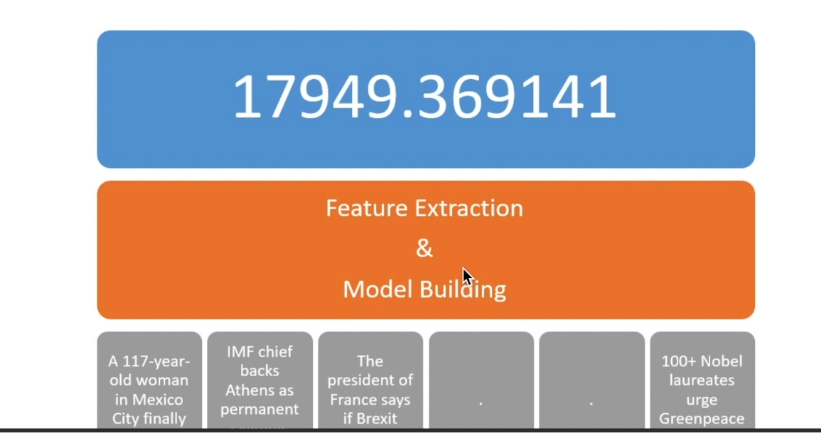

# Installation Prerequisites

In [2]:
#!apt-get update  && apt-get install -y --allow-downgrades --no-install-recommends git wget 

In [3]:
#!apt-get -y install graphviz

In [4]:
#!pip install nltk keras

In [5]:
#!pip install pydot

In [6]:
#!pip install graphviz

In [7]:
!wget http://nlp.stanford.edu/data/glove.840B.300d.zip

--2022-01-28 18:09:55--  http://nlp.stanford.edu/data/glove.840B.300d.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.840B.300d.zip [following]
--2022-01-28 18:09:55--  https://nlp.stanford.edu/data/glove.840B.300d.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.840B.300d.zip [following]
--2022-01-28 18:09:55--  http://downloads.cs.stanford.edu/nlp/data/glove.840B.300d.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2176768927 (2.0G) [application/zip

In [8]:
!unzip glove.840B.300d.zip

Archive:  glove.840B.300d.zip
  inflating: glove.840B.300d.txt     


# Imports

In [9]:
import pandas as pd
import numpy as np
import tensorflow as tf
import re
import nltk
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.metrics import median_absolute_error as mae
from sklearn.metrics import mean_squared_error as mse
import matplotlib.pyplot as plt

In [10]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [11]:
# Keras Imports
from keras.models import Sequential
from keras import initializers
from keras.layers import Dropout, Activation, Embedding, Convolution1D, MaxPooling1D, Input, Dense, add, \
                         BatchNormalization, Flatten, Reshape, Concatenate
from keras.layers.recurrent import LSTM, GRU
from keras.callbacks import Callback, ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.models import Model
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from keras import regularizers
from keras.utils.vis_utils import plot_model
import re

## connection with drive

In [12]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [13]:
dj = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/dowjones-news-data/DowJones.csv")
news = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/dowjones-news-data/News.csv")

## Inspect the data

In [14]:
dj.head()

,Date,Open,High,Low,Close,Volume,Adj Close
0,01-07-2016,17924.24023,18002.38086,17916.91016,17949.36914,82160000,17949.36914
1,30-06-2016,17712.75977,17930.60938,17711.80078,17929.99023,133030000,17929.99023
2,29-06-2016,17456.01953,17704.50977,17456.01953,17694.67969,106380000,17694.67969
3,28-06-2016,17190.50977,17409.72070,17190.50977,17409.72070,112190000,17409.72070
4,27-06-2016,17355.21094,17355.21094,17063.08008,17140.24023,138740000,17140.24023


In [15]:
news.head()

,Date,News
0,01-07-2016,A 117-year-old woman in Mexico City finally re...
1,01-07-2016,IMF chief backs Athens as permanent Olympic host
2,01-07-2016,"The president of France says if Brexit won, so..."
3,01-07-2016,British Man Who Must Give Police 24 Hours' Not...
4,01-07-2016,100+ Nobel laureates urge Greenpeace to stop o...


## Check for null

In [16]:
dj.isnull().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Volume       0
Adj Close    0
dtype: int64

In [17]:
news.isnull().sum()

Date    0
News    0
dtype: int64

## Shape of the data

In [18]:
print(dj.shape)
print("-"*100)
print(news.shape)

(1989, 7)
----------------------------------------------------------------------------------------------------
(73608, 2)


In [19]:
# Compare the number of unique dates. We want matching values.
print(len(set(dj["Date"])))
print(len(set(news["Date"])))

1989
2943


### We want Dates according to DOW Jones stock file which is DJ, so we drop the dates which was not in DJ

### In order to remove dates in news datset which was not in DOW JONES(D.J)

## first way

In [20]:
dt=[]
for i in set(news["Date"]):
  if i not in set(dj["Date"]):
    dt.append(i)
len(dt)

954

### From this DT we can now exclude dates which are not in news

# Second way

In [21]:
dj_unique=dj.drop_duplicates(subset="Date",keep=False)
len(dj_unique)

1989

In [22]:
news_unique=news.drop_duplicates(subset="Date")
len(news_unique)

2943

In [23]:
len(pd.merge(dj_unique,news_unique,how="inner",on="Date"))

1989

## Alternatively

In [24]:
news=news[news["Date"].isin(dj["Date"])]

In [25]:
print(len(set(dj.Date)))
print(len(set(news.Date)))

1989
1989


In [26]:
dj.head()

,Date,Open,High,Low,Close,Volume,Adj Close
0,01-07-2016,17924.24023,18002.38086,17916.91016,17949.36914,82160000,17949.36914
1,30-06-2016,17712.75977,17930.60938,17711.80078,17929.99023,133030000,17929.99023
2,29-06-2016,17456.01953,17704.50977,17456.01953,17694.67969,106380000,17694.67969
3,28-06-2016,17190.50977,17409.72070,17190.50977,17409.72070,112190000,17409.72070
4,27-06-2016,17355.21094,17355.21094,17063.08008,17140.24023,138740000,17140.24023


In [27]:
news.head()

,Date,News
0,01-07-2016,A 117-year-old woman in Mexico City finally re...
1,01-07-2016,IMF chief backs Athens as permanent Olympic host
2,01-07-2016,"The president of France says if Brexit won, so..."
3,01-07-2016,British Man Who Must Give Police 24 Hours' Not...
4,01-07-2016,100+ Nobel laureates urge Greenpeace to stop o...


## Next task is to append all headlines of News according to date, and same appended headline is same as the price(i.e Open) in Dow Jones in DJ dataset. so dependent is Price and independent is Headlines
**like--->**
<table size="100">
    <tr>
        <td><b>headlines<td>
        <td><b>price</td>
    </tr>
    <tr>
        <td><b>headline-1, headline-2 ..., headline-n</td>
        <td><b>211.48</td>
    </tr>
</table> 

# We use iterrows() for this--

### for example

In [28]:
import pandas as pd

data = {
  "firstname": ["Sally", "Mary", "John"],
  "age": [50, 40, 30]
}

df = pd.DataFrame(data)

for index, row in df.iterrows():
    print(row["firstname"])

Sally
Mary
John


In [29]:
for i,j in df.iterrows():
    print("Index is--",i,"Name is",j["firstname"])
  


Index is-- 0 Name is Sally
Index is-- 1 Name is Mary
Index is-- 2 Name is John


In [30]:
for i in df.iterrows():
    print(i[0])

0
1
2


In [31]:
for i in df.iterrows():
    print(i[1]["firstname"])

Sally
Mary
John


###---------------------------------------------Example Ends----------------------------------------------

## Combine the two datasets - For each date, get all the headlines and the price

In [32]:
# Create a list of the opening prices and their corresponding daily headlines from the news
# Define/Initialize the variables
price = []
headlines = []

# For all the rows in the dataframe
for row in dj.iterrows():
    # define a new variable to store all the headlines for the day
    daily_headlines = []
    # Spot the date in the given row
    date = row[1]['Date']
    # Store the price for the date
    price.append(row[1]['Open'])
    for row_ in news[news.Date==date].iterrows():
        daily_headlines.append(row_[1]['News'])

    # Append the headlines for the date
    headlines.append(daily_headlines)
    # Track progress
    if len(price) % 500 == 0:
        print(len(price))

500
1000
1500


In [33]:
# Check how headlines look like
headlines[:1], price[:1]

([['A 117-year-old woman in Mexico City finally received her birth certificate, and died a few hours later. Trinidad Alvarez Lira had waited years for proof that she had been born in 1898.',
   'IMF chief backs Athens as permanent Olympic host',
   'The president of France says if Brexit won, so can Donald Trump',
   "British Man Who Must Give Police 24 Hours' Notice of Sex Threatens Hunger Strike: The man is the subject of a sexual risk order despite having never been convicted of a crime.",
   '100+ Nobel laureates urge Greenpeace to stop opposing GMOs',
   'Brazil: Huge spike in number of police killings in Rio ahead of Olympics',
   "Austria's highest court annuls presidential election narrowly lost by right-wing candidate.",
   "Facebook wins privacy case, can track any Belgian it wants: Doesn't matter if Internet users are logged into Facebook or not",
   'Switzerland denies Muslim girls citizenship after they refuse to swim with boys at school: The 12- and 14-year-old will no lo

In [34]:
# Check how headlines look like
print("The Headline length is {}, and the price is {}".format(len(headlines), len(price)))

The Headline length is 1989, and the price is 1989


### removing unwanted Extra features fom dow jones

In [35]:
# Remove unwanted features - keep the 'Open' price only
dj = dj.drop(['High','Low','Close','Volume','Adj Close'], 1)
dj.head()

,Date,Open
0,01-07-2016,17924.24023
1,30-06-2016,17712.75977
2,29-06-2016,17456.01953
3,28-06-2016,17190.50977
4,27-06-2016,17355.21094


In [36]:
# Calculate the difference in opening prices between the following and current day.
# The model will try to predict the change in Open value based on the today's news.
dj = dj.set_index('Date')
dj.head()

,Open
Date,
01-07-2016,17924.24023
30-06-2016,17712.75977
29-06-2016,17456.01953
28-06-2016,17190.50977
27-06-2016,17355.21094


## Target variable = Tomorrow's Open Price - Today's Open Price, coz todays headline will decide tomorrows stock price

In [37]:
# Target variable = Tomorrow's Open Price - Today's Open Price
dj = -1 * dj.diff(periods=1)
dj.head()

,Open
Date,
01-07-2016,NaN
30-06-2016,211.48046
29-06-2016,256.74024
28-06-2016,265.50976
27-06-2016,-164.70117


In [38]:
dj["Date"]=dj.index
dj=dj.reset_index(drop=True)
dj.head()

,Open,Date
0,NaN,01-07-2016
1,211.48046,30-06-2016
2,256.74024,29-06-2016
3,265.50976,28-06-2016
4,-164.70117,27-06-2016


In [39]:
# Remove top row since it has a null value.
add=np.where(dj["Open"].isnull()==True)
add

(array([0]),)

## Alternate Way

In [40]:
dj=dj[dj["Open"].notnull()]
dj.head()

,Open,Date
1,211.48046,30-06-2016
2,256.74024,29-06-2016
3,265.50976,28-06-2016
4,-164.70117,27-06-2016
5,-591.41992,24-06-2016


In [41]:
##checking null again
dj.isnull().sum()

Open    0
Date    0
dtype: int64

## Clean up the price list

In [42]:
price[:2]

[17924.24023, 17712.75977]

## Normalize the Price

In [43]:
# Normalize opening prices (target values)
max_price = max(price)
min_price = min(price)
mean_price = np.mean(price)
def normalize(price):
    return ((price-min_price)/(max_price-min_price))

In [44]:
norm_price = []
for p in price:
    norm_price.append(normalize(p))

In [45]:
# Check that normalization worked well
print(min(norm_price))
print(max(norm_price))
print(np.mean(norm_price))

0.0
1.0
0.5873620372359045


In [46]:
norm_price[:2]

[0.9667897150366344, 0.9488189853141274]

## Clean up the headlines list

In [47]:
# remove contractions
def decontracted(phrase):
    if "'" in phrase:
        # specific
        phrase = re.sub(r"won't", "will not", phrase)
        phrase = re.sub(r"can\'t", "can not", phrase)

        # general
        phrase = re.sub(r"n\'t", " not", phrase)
        phrase = re.sub(r"\'re", " are", phrase)
        phrase = re.sub(r"\'s", " is", phrase)
        phrase = re.sub(r"\'d", " would", phrase)
        phrase = re.sub(r"\'ll", " will", phrase)
        phrase = re.sub(r"\'t", " not", phrase)
        phrase = re.sub(r"\'ve", " have", phrase)
        phrase = re.sub(r"\'m", " am", phrase)
    return phrase

text = "I should've gone to dentist so my teeth wouldn't hurt"
text1 = "But I am good now"
print(decontracted(text))
print(decontracted(text1))

I should have gone to dentist so my teeth would not hurt
But I am good now


In [48]:
def clean_text(text):
    '''Remove unwanted characters and format the text to create fewer nulls word embeddings'''
    
    # Convert words to lower case
    text = text.lower()
    
    # Replace contractions with their longer forms 
    if True:
        text = text.split()
        new_text = []
        # Remove the contractions
        for word in text:
            new_text.append(decontracted(word))
        # Recreate the sentence
        text = " ".join(new_text)
    
    # Format words and remove unwanted characters
    text = re.sub(r'&amp;', '', text) 
    text = re.sub(r'0,0', '00', text) 
    text = re.sub(r'[_"\-;%()|.,+&=*%.,!?:#@\[\]]', ' ', text)
    text = re.sub(r'\'', ' ', text)
    text = re.sub(r'\$', ' $ ', text)
    text = re.sub(r'u s ', ' united states ', text)
    text = re.sub(r'u n ', ' united nations ', text)
    text = re.sub(r'u k ', ' united kingdom ', text)
    text = re.sub(r'j k ', ' jk ', text)
    text = re.sub(r' s ', ' ', text)
    text = re.sub(r' yr ', ' year ', text)
    text = re.sub(r' l g b t ', ' lgbt ', text)
    text = re.sub(r'0km ', '0 km ', text)
    
    # Remove stop words
    text = text.split()
    stops = set(stopwords.words("english"))
    text = [w for w in text if not w in stops]
    text = " ".join(text)

    return text

In [49]:
# Clean the headlines
clean_headlines = []

for daily_headlines in headlines:
    clean_daily_headlines = []
    for headline in daily_headlines:
        clean_daily_headlines.append(clean_text(headline))
    clean_headlines.append(clean_daily_headlines)
  


In [50]:
clean_headlines[0]

['117 year old woman mexico city finally received birth certificate died hours later trinidad alvarez lira waited years proof born 1898',
 'imf chief backs athens permanent olympic host',
 'president france says brexit donald trump',
 'british man must give police 24 hours notice sex threatens hunger strike man subject sexual risk order despite never convicted crime',
 '100 nobel laureates urge greenpeace stop opposing gmos',
 'brazil huge spike number police killings rio ahead olympics',
 'austria highest court annuls presidential election narrowly lost right wing candidate',
 'facebook wins privacy case track belgian wants matter internet users logged facebook',
 'switzerland denies muslim girls citizenship refuse swim boys school 12 14 year old longer considered naturalised citizenship complied school curriculum authorities basel said',
 'china kills millions innocent meditators organs report finds',
 'france cracks factory farms viral video campaign moved govt act footage shared wi

## count the unique elements in the dictionary

In [51]:
sm=set()
for i in clean_headlines:
  for j in i:
    for k in j.split():
      sm.add(k)


In [52]:
s=0
for i in sm:
  s=s+1
s


36319

# Alternatively we can do this

In [53]:
print('Roughly the number of unique words in English: {}'.format(len({word: None 
                                                                      for headlines in clean_headlines 
                                                                      for headline in headlines 
                                                                      for word in headline.split()})))

Roughly the number of unique words in English: 36319


## Creating the counter of the words

In [54]:
# Create the word vocab
import collections
words = [word for headlines in clean_headlines for headline in headlines for word in headline.split()]
word_counts = collections.Counter(words)
word_counts

Counter({'117': 4,
         'year': 1683,
         'old': 919,
         'woman': 590,
         'mexico': 551,
         'city': 646,
         'finally': 115,
         'received': 92,
         'birth': 96,
         'certificate': 12,
         'died': 271,
         'hours': 268,
         'later': 117,
         'trinidad': 3,
         'alvarez': 1,
         'lira': 2,
         'waited': 6,
         'years': 1545,
         'proof': 53,
         'born': 105,
         '1898': 1,
         'imf': 88,
         'chief': 413,
         'backs': 68,
         'athens': 58,
         'permanent': 36,
         'olympic': 86,
         'host': 71,
         'president': 1424,
         'france': 661,
         'says': 2564,
         'brexit': 24,
         'donald': 28,
         'trump': 44,
         'british': 862,
         'man': 930,
         'must': 375,
         'give': 290,
         'police': 1966,
         '24': 135,
         'notice': 30,
         'sex': 547,
         'threatens': 236,
         'hunge

# A note on Word Embeddings

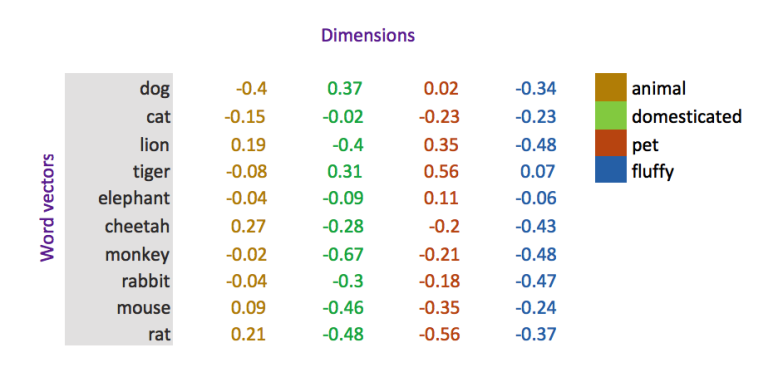
**Reference**: https://nlp.stanford.edu/projects/glove/

## We are going to use Glove embeddings to initialize our weights while designing our neural network. Let's load the same so that we can ensure our headline corpus' vocabulary matches where possible with Glove Embedding vocabulary.

In [55]:
# Load GloVe's embeddings
embeddings_index = {}
with open('/content/glove.840B.300d.txt', encoding='utf-8') as f:
    for line in f:
        values = line.split(' ')
        word = values[0]
        embedding = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = embedding

print('Word embeddings:', len(embeddings_index))

Word embeddings: 2196016


## It is not necessary that we will have embeddings for all the words in Glove. So to limit such cases by limiting vocabulary by applying simple logic:  Remove the words that are "rare" and are not available in Glove 

In [56]:
# Limit the vocab that we will use to words that appear ≥ threshold or are in GloVe

# Define threshold
threshold = 10

#dictionary to convert words to integers
vocab_to_int = {} 

value = 0
for word,count in word_counts.items():
  if count >=threshold or word in embeddings_index:
    vocab_to_int[word]=value
    value=value+1

In [57]:
len(vocab_to_int)

31303

## padding the words in vocab_to_int and the words which are not present in glove replace them with len(vocab_to_int)

In [58]:
# Special tokens that will be added to our vocab
codes = ["<UNK>","<PAD>"]   

# Add codes to vocab
for code in codes:
    vocab_to_int[code] = len(vocab_to_int)

# Dictionary to convert integers to words
int_to_vocab = {}
for word, value in vocab_to_int.items():
    int_to_vocab[value] = word

usage_ratio = round(len(vocab_to_int) / len(word_counts),4)*100

print("Total Number of Unique Words:", len(word_counts))
print("Number of Words we will use:", len(vocab_to_int))
print("Percent of Words we will use: {}%".format(usage_ratio))

Total Number of Unique Words: 36319
Number of Words we will use: 31305
Percent of Words we will use: 86.19%


### Code explaination

In [59]:
sam={'117': 0,'year': 1,'old': 2,'woman': 3,'mexico': 4,'city': 5}
print(sam)
print(len(sam))

{'117': 0, 'year': 1, 'old': 2, 'woman': 3, 'mexico': 4, 'city': 5}
6


In [60]:
codes = ["<UNK>","<PAD>"]  
for code in codes:
    sam[code] = len(sam)
sam

{'117': 0,
 '<PAD>': 7,
 '<UNK>': 6,
 'city': 5,
 'mexico': 4,
 'old': 2,
 'woman': 3,
 'year': 1}

### Explaination End--------------------------

## For the words which are common within headlines but are absent in Glove corpus, we will have to randomly initialize them. Over the training, those values will be finetuned along with those of Glove vectors.

In [61]:
# Need to use 300 for embedding dimensions to match GloVe's vectors.
embedding_dim = 300

nb_words = len(vocab_to_int)
# Create matrix with default values of zero
word_embedding_matrix = np.zeros((nb_words, embedding_dim)) # intiializing a (0,0) matrix
for word, i in vocab_to_int.items():
    if word in embeddings_index:
        word_embedding_matrix[i] = embeddings_index[word] # putting the matrix with the index of the word which is present in glove
    else:
        # If word not in GloVe, create a random embedding for it
        new_embedding = np.array(np.random.uniform(-1.0, 1.0, embedding_dim)) # Setting up a random number unfiromly distributed if word is not present in Glove
        embeddings_index[word] = new_embedding
        word_embedding_matrix[i] = new_embedding

# Check if value matches len(vocab_to_int)
print(len(word_embedding_matrix))

31305


In [62]:
mat=np.zeros((3,3))
mat

array([[0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.]])

In [63]:
for i in range(2):
  mat[i]=5
mat

array([[5., 5., 5.],
       [5., 5., 5.],
       [0., 0., 0.]])

## Convert the word sequences to equivalent integer sequences so that it can be used as input to the model

In [64]:
# Change the text from words to integers
# If word is not in vocab, replace it with <UNK> (unknown)
word_count = 0
unk_count = 0

headlines_sequence = []

for daily_headline in clean_headlines:
    daily_headlines_seq = []
    for headline in daily_headline:
        headline_seq = []
        for word in headline.split():
            word_count += 1
            if word in vocab_to_int:
                headline_seq.append(vocab_to_int[word])
            else:
                headline_seq.append(vocab_to_int["<UNK>"])
                unk_count += 1
        daily_headlines_seq.append(headline_seq)
    headlines_sequence.append(daily_headlines_seq)

unk_percent = round(unk_count/word_count,4)*100

print("Total number of words in headlines:", word_count)
print("Total number of UNKs in headlines:", unk_count)
print("Percent of words that are UNK: {}%".format(unk_percent))

Total number of words in headlines: 617046
Total number of UNKs in headlines: 7141
Percent of words that are UNK: 1.16%


In [65]:
headlines_sequence[:1]

[[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20],
  [21, 22, 23, 24, 25, 26, 27],
  [28, 29, 30, 31, 32, 33],
  [34,
   35,
   36,
   37,
   38,
   39,
   11,
   40,
   41,
   42,
   43,
   44,
   35,
   45,
   46,
   47,
   48,
   49,
   50,
   51,
   52],
  [53, 54, 55, 56, 57, 58, 59, 60],
  [61, 62, 63, 64, 38, 65, 66, 67, 68],
  [69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79],
  [80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 80],
  [91,
   92,
   93,
   94,
   95,
   96,
   97,
   98,
   99,
   100,
   101,
   1,
   2,
   102,
   103,
   104,
   95,
   105,
   99,
   106,
   107,
   108,
   109],
  [110, 111, 112, 113, 114, 115, 116, 117],
  [29,
   118,
   119,
   120,
   121,
   122,
   123,
   124,
   125,
   126,
   127,
   128,
   129,
   130,
   131,
   132,
   133,
   134,
   135,
   136,
   137,
   138,
   139,
   140,
   141,
   142],
  [143, 144, 145, 146, 147, 148, 1, 2, 149, 150, 151, 152],
  [153, 154, 155, 156, 157, 158, 110],
  [159, 160, 149,

## Ensure that the variations in the number of news headlines each day and length of each headlines are handled by taking an average number of headlines each day and average length per headline 

In [66]:
# Find the length of headlines
lengths = []
for headlines in headlines_sequence:
    for headline in headlines:
        lengths.append(len(headline))

# Create a dataframe so that the values can be inspected
lengths = pd.DataFrame(lengths, columns=['counts'])

In [67]:
lengths.describe()

,counts
count,49718.000000
mean,12.410918
std,6.790458
min,1.000000
25%,7.000000
50%,10.000000
75%,16.000000
max,41.000000


## Limit the length of a day's news to 200 words, and the length of any headline to 16 words. These values are chosen to not have an excessively long training time and balance the number of headlines used and the number of words from each headline.

For each day, there are multiple headlines and each headline has a variable length. Therefore, the padding task was two-fold:

For a headline having less than 16 words, append it as it. For a headline that is longer than 16 words, truncate it from the right and append the first 16 words only.
Combine all the headlines into a single headline and pad it to a length of 200 words in case it is shorter than 200 words. In case it is longer than 200 words, truncate it from the right side.

In [68]:
max_headline_length = 16
max_daily_length = 200
pad_headlines = []

# For each date in all the dates available
for headlines in headlines_sequence:
    pad_daily_headlines = []
    # for each headline for each date
    for headline in headlines:
        # Add headline if it is less than max length
        if len(headline) <= max_headline_length:
            for word in headline:
                pad_daily_headlines.append(word)
        # Limit headline if it is more than max length  
        else:
            headline = headline[:max_headline_length]
            for word in headline:
                pad_daily_headlines.append(word)
    
    # Pad daily_headlines if they are less than max length
    if len(pad_daily_headlines) < max_daily_length:
        for i in range(max_daily_length-len(pad_daily_headlines)):
            pad = vocab_to_int["<PAD>"]
            pad_daily_headlines.append(pad)
    # Limit daily_headlines if they are more than max length
    else:
        pad_daily_headlines = pad_daily_headlines[:max_daily_length]
    pad_headlines.append(pad_daily_headlines)

## Split data into training and testing sets.
## Validating data will be created during training.

In [69]:
x_train, x_test, y_train, y_test = train_test_split(pad_headlines, norm_price, test_size = 0.15, random_state = 2)

x_train = np.array(x_train)
x_test = np.array(x_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

In [70]:
# Check the lengths
print(len(x_train))
print(len(x_test))

1690
299


# Model Building
## The CNN-RNN architecture
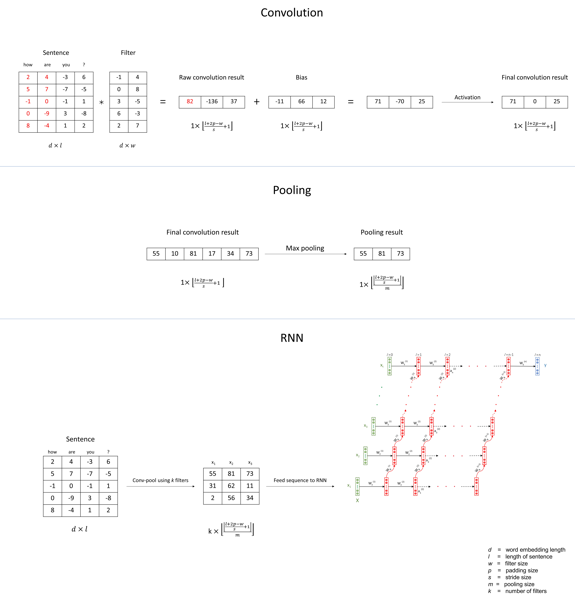

## 1. Define the hyperparameters

In [71]:
filter_length = 5
dropout = 0.5
learning_rate = 0.001
weights = initializers.TruncatedNormal(mean=0.0, stddev=0.1, seed=2)
nb_filter = 16
rnn_output_size = 128
hidden_dims = 128

## 2. Create the model

In [72]:
def build_model():
    
    model = Sequential()
    
    # Layer 1 - Embedding
    model.add(Embedding(nb_words, 
                         embedding_dim,
                         weights=[word_embedding_matrix], 
                         input_length=max_daily_length))
    model.add(Dropout(dropout))
    
    # Layer 2 - Convolution 1 with dropout
    model.add(Convolution1D(filters = nb_filter, 
                             kernel_size = filter_length, 
                             padding = 'same',
                             activation = 'relu'))
    model.add(Dropout(dropout))    

    # Layer 3 - Convolution 2 with Dropout 
    model.add(Convolution1D(filters = nb_filter, 
                                 kernel_size = filter_length, 
                                 padding = 'same',
                                 activation = 'relu'))
    model.add(Dropout(dropout))    

    # Layer 4 - RNN with dropout
    model.add(LSTM(rnn_output_size, 
                    activation=None,
                    kernel_initializer=weights,
                    dropout = dropout))    

    # Layer 5 - Dense FFN with Dropout
    model.add(Dense(hidden_dims, kernel_initializer=weights))
    model.add(Dropout(dropout))
    
    model.add(Dense(1, 
                    kernel_initializer = weights,
                    name='output'))

    model.compile(loss='mean_squared_error',
                  optimizer=Adam(lr=learning_rate,clipvalue=1.0))
    return model

## 3. Fit the model

In [73]:
model = build_model()
print()
save_best_weights = 'best_weights.h5'

callbacks = [ModelCheckpoint(save_best_weights, monitor='val_loss', save_best_only=True),
            EarlyStopping(monitor='val_loss', patience=5, verbose=1, mode='auto'),
            ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience=3)]

history = model.fit([x_train],
                    y_train,
                    batch_size=128,
                    epochs=100,
                    validation_split=0.15,
                    verbose=True,
                    shuffle=True,
                    callbacks = callbacks)
print(model.summary())

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)



Epoch 1/100
12/12 [==============================] - 30s 1s/step - loss: 0.1835 - val_loss: 0.1896 - lr: 0.0010
Epoch 2/100
12/12 [==============================] - 14s 1s/step - loss: 0.1064 - val_loss: 0.1304 - lr: 0.0010
Epoch 3/100
12/12 [==============================] - 13s 1s/step - loss: 0.0889 - val_loss: 0.1114 - lr: 0.0010
Epoch 4/100
12/12 [==============================] - 14s 1s/step - loss: 0.0789 - val_loss: 0.0966 - lr: 0.0010
Epoch 5/100
12/12 [==============================] - 15s 1s/step - loss: 0.0754 - val_loss: 0.0874 - lr: 0.0010
Epoch 6/100
12/12 [==============================] - 16s 1s/step - loss: 0.0726 - val_loss: 0.0859 - lr: 0.0010
Epoch 7/100
12/12 [==============================] - 15s 1s/step - loss: 0.0669 - val_loss: 0.0816 - lr: 0.0010
Epoch 8/100
12/12 [==============================] - 14s 1s/step - loss: 0.0651 - val_loss: 0.0759 - lr: 0.0010
Epoch 9/100
12/12 [==============================] - 14s 1s/step - loss: 0.0612 - val_loss: 0.0859 - lr

## 4. Predict using the model

In [74]:
predictions = model.predict([x_test], verbose = True)

10/10 [==============================] - 3s 213ms/step


In [75]:
# Compare testing loss to training and validating loss
mse(y_test, predictions)

0.1170937102070089

In [76]:
# Revert prediction back to actual scale
def unnormalize(price):
    '''Revert values to their unnormalized amounts'''
    price = price*(max_price-min_price)+min_price
    return(price)

In [77]:
# Store back-scaled predictions
unnorm_predictions = []
for pred in predictions:
    unnorm_predictions.append(unnormalize(pred))

# Store back-scaled actuals
unnorm_y_test = []
for y in y_test:
    unnorm_y_test.append(unnormalize(y))

In [78]:
# Calculate the median absolute error for the predictions
mae(unnorm_y_test, unnorm_predictions)

2663.584963437501

In [79]:
pd.Series(unnorm_y_test).describe()

count      299.000000
mean     13409.926321
std       3245.815273
min       7167.350098
25%      10565.620115
50%      13072.870120
75%      16546.355465
max      18286.869140
dtype: float64

## Make Your Own Predictions
Below is the code necessary to make your own predictions. I found that the predictions are most accurate when there is no padding included in the input data. In the create_news variable, I have some default news that you can use, which is from April 30th, 2017. Just change the text to whatever you want, then see the impact your new headline will have.

In [80]:
def news_to_int(news):
    '''Convert your created news into integers'''
    ints = []
    for word in news.split():
        if word in vocab_to_int:
            ints.append(vocab_to_int[word])
        else:
            ints.append(vocab_to_int['<UNK>'])
    return ints

In [81]:
def padding_news(news):
    '''Adjusts the length of your created news to fit the model's input values.'''
    padded_news = news
    if len(padded_news) < max_daily_length:
        for i in range(max_daily_length-len(padded_news)):
            padded_news.append(vocab_to_int["<PAD>"])
    elif len(padded_news) > max_daily_length:
        padded_news = padded_news[:max_daily_length]
    return padded_news

In [82]:
# Default news that you can use

create_news =  "Woman says note from Chinese 'prisoner' was hidden in new purse. \
               21,000 AT&T workers poised for Monday strike \
               housands march against Trump climate policies in D.C., across USA \
               Kentucky judge won't hear gay adoptions because it's not in the child's \"best interest\" \
               Multiple victims shot in UTC area apartment complex \
               Drones Lead Police to Illegal Dumping in Riverside County | NBC Southern California \
               An 86-year-old Californian woman has died trying to fight a man who was allegedly sexually assaulting her 61-year-old friend. \
               Fyre Festival Named in $5Million+ Lawsuit after Stranding Festival-Goers on Island with Little Food, No Security. \
               The \"Greatest Show on Earth\" folds its tent for good \
               U.S.-led fight on ISIS have killed 352 civilians: Pentagon \
               Woman offers undercover officer sex for $25 and some Chicken McNuggets \
               Ohio bridge refuses to fall down after three implosion attempts \
               Jersey Shore MIT grad dies in prank falling from library dome \
               New York graffiti artists claim McDonald's stole work for latest burger campaign \
               SpaceX to launch secretive satellite for U.S. intelligence agency \
               Severe Storms Leave a Trail of Death and Destruction Through the U.S. \
               Hamas thanks N. Korea for its support against ‘Israeli occupation’ \
               Baker Police officer arrested for allegedly covering up details in shots fired investigation \
               Miami doctor’s call to broker during baby’s delivery leads to $33.8 million judgment \
               Minnesota man gets 15 years for shooting 5 Black Lives Matter protesters \
               South Australian woman facing possible 25 years in Colombian prison for drug trafficking \
               The Latest: Deal reached on funding government through Sept. \
               Russia flaunts Arctic expansion with new military bases"

clean_news = clean_text(create_news)

int_news = news_to_int(clean_news)

pad_news = padding_news(int_news)

pad_news = np.array(pad_news).reshape((1,-1))

pred = model.predict([pad_news])

price_change = unnormalize(pred)

print("The Dow should open: {} from the previous open.".format(np.round(price_change[0][0],2)))

The Dow should open: 9930.98046875 from the previous open.
